## Welcome

This is material for the **Regression Discontinuity** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)


In [11]:
# !pip install stargazer

In [12]:
import pandas as pd
import numpy as np
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    full_path = "https://github.com/scunning1975/mixtape/raw/master/" + file
    
    return pd.read_stata(full_path)
    

## Data Preprocess

In [15]:
Eth = pd.read_csv("https://raw.githubusercontent.com/Rising-Stars-by-Sunshine/Haowen-STATS201-Final/main/data/Causal%20Inference/Ethereum_Data.csv")

In [16]:
Eth.columns = ["Time","Price"]

In [17]:
Eth.describe()

,Price
count,2757.000000
mean,820.258804
std,1100.565495
min,0.420000
25%,114.873849
50%,273.289949
75%,1263.208619
max,4811.156463


In [18]:
Eth.head()

,Time,Price
0,2015/8/8,1.19999
1,2015/8/9,1.19999
2,2015/8/10,1.19999
3,2015/8/11,0.99000
4,2015/8/12,1.28800


In [19]:
Eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    2757 non-null   object 
 1   Price   2757 non-null   float64
dtypes: float64(1), object(1)
memory usage: 43.2+ KB


In [20]:
Eth.Time = pd.to_datetime(Eth.Time)
Eth.set_index("Time", inplace=True)

In [21]:
Eth.head()

,Price
Time,
2015-08-08,1.19999
2015-08-09,1.19999
2015-08-10,1.19999
2015-08-11,0.99000
2015-08-12,1.28800


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10) 
plt.rcParams["lines.linewidth"] = 1
plt.style.use("ggplot")

In [23]:
# FTX files for Chapter 11 bankruptcy protection
FTX_b = Eth.index[2652]
# Bankruptcy start
FTX_s = Eth.index[2647]
Eth.index[2652]

Timestamp('2022-11-11 00:00:00')

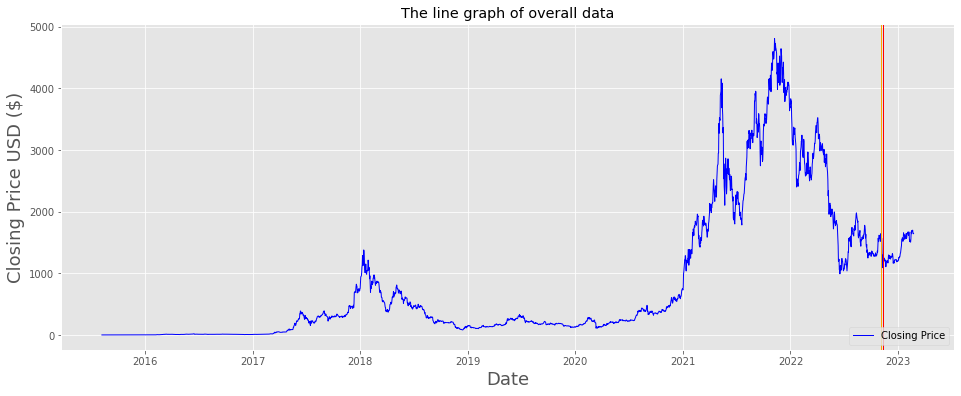

In [24]:
plt.figure(figsize=(16, 6))
plt.title('The line graph of overall data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.plot(Eth['Price'],c="b")
plt.legend(['Closing Price'], loc='lower right')
plt.axvline(FTX_s,c="orange")
plt.axvline(FTX_b,c="r")
plt.savefig("Overall.png")
plt.show()


## RDD Simulation

Generate a simple Regression Discontinuity, before and after the treatment is given. 

In [25]:
# dat = pd.DataFrame({'x': np.random.normal(50, 25, 1000)})
# dat.loc[dat.x<0, 'x'] = 0
# dat = dat[dat.x<100]
# dat['D'] = 0
# dat.loc[dat.x>50, 'D'] = 1
# dat['y1'] = 25 + 0*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
# dat['y2'] = 25 + 40*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
# print('"Counterfactual Potential Outcomes')

In [26]:
# p.ggplot(dat, p.aes(x='x', y='y1', color = 'factor(D)')) +\
#     p.geom_point(alpha = 0.5) +\
#     p.geom_vline(xintercept = 50, colour = "grey") +\
#     p.stat_smooth(method = "lm", se = 'F') +\
#     p.labs(x = "Test score (X)", y = "Potential Outcome (Y1)")

In [27]:
# Get the valid data
start = pd.Timestamp('2022-10-01 00:00:00')
end = pd.Timestamp('2022-12-29 00:00:00')
data = Eth.loc[Eth.index < end]
data = data.loc[data.index > start]
data['D'] = 0
data.loc[data.index>FTX_b, 'D'] = 1
data.head()

,Price,D
Time,,
2022-10-02,1276.553047,0
2022-10-03,1324.409983,0
2022-10-04,1362.843952,0
2022-10-05,1352.557207,0
2022-10-06,1351.353740,0


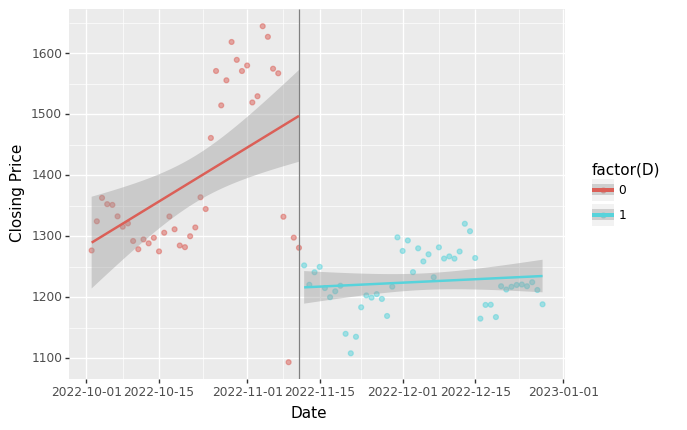

<ggplot: (8737442150075)>

In [28]:
p.ggplot(data, p.aes(x= 'data.index', y= 'data.Price', color = 'factor(D)')) +\
    p.geom_point(alpha = 0.5) +\
    p.geom_vline(xintercept = FTX_b, colour = "grey") +\
    p.stat_smooth(method = "lm", se = 'F') +\
    p.labs(x = "Date", y = "Closing Price")

In [29]:
# Get the valid data
start = pd.Timestamp('2022-10-01 00:00:00')
end = pd.Timestamp('2022-12-29 00:00:00')
data = Eth.loc[Eth.index < end]
data = data.loc[data.index > start]
data['D'] = 0
data.loc[data.index>FTX_s, 'D'] = 1
data.head()

,Price,D
Time,,
2022-10-02,1276.553047,0
2022-10-03,1324.409983,0
2022-10-04,1362.843952,0
2022-10-05,1352.557207,0
2022-10-06,1351.353740,0


In [30]:
np.random.seed(12282020)

# Fully interacted regression
all_columns = "+".join(data.columns.difference(["D", 'data.Price']))
formula = 'data.Price ~ D * ({})'.format(all_columns)

regression = sm.OLS.from_formula(formula, data = data).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             data.Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.380e+29
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:20:35   Log-Likelihood:                 2313.5
No. Observations:                  88   AIC:                            -4619.
Df Residuals:                      84   BIC:                            -4609.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.411e-12   1.75e-12     -1.945      0.055    -6.9e-12    7.66e-14
D           1.137e-12   2.93e-12      0.388      0.699   -4.69e-12    6.97e-12
Price          1.0000   1.24e-15   8.04e+14      0.000       1.000       1.000
D:Price    -1.332e-15   2.27e-15     -0.587      0.559   -5.85e-15    3.18e-15
==============================================================================
Omnibus:                       11.927   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.865
Skew:                          -0.780   Prob(JB):                      0.00437
Kurtosis:                       2.274   Cond. No.                     4.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

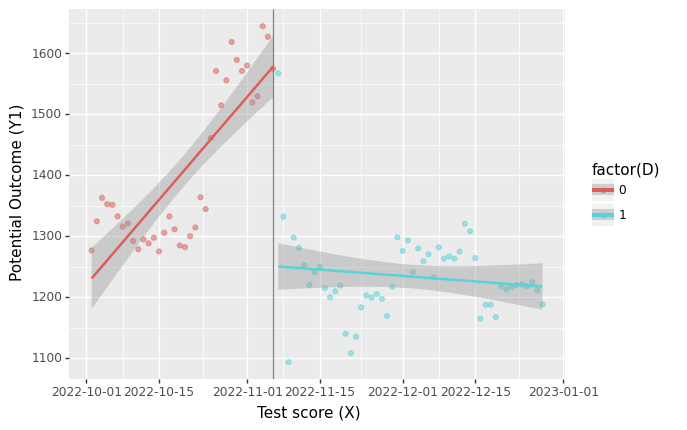

<ggplot: (8737439280150)>

In [31]:
p.ggplot(data, p.aes(x= 'data.index', y= 'data.Price', color = 'factor(D)')) +\
    p.geom_point(alpha = 0.5) +\
    p.geom_vline(xintercept = FTX_s, colour = "grey") +\
    p.stat_smooth(method = "lm", se = 'F') +\
    p.labs(x = "Test score (X)", y = "Potential Outcome (Y1)")

#### Questions
- If you estimated the treatment effect using the linear model, would your treatment effect estimate be near the true treatment effect? 



In [33]:
np.random.seed(12282020)

# Fully interacted regression
all_columns = "+".join(data.columns.difference(["D", 'data.Price']))
formula = 'data.Price ~ D * ({})'.format(all_columns)

regression = sm.OLS.from_formula(formula, data = data).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             data.Price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.380e+29
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:20:44   Log-Likelihood:                 2313.5
No. Observations:                  88   AIC:                            -4619.
Df Residuals:                      84   BIC:                            -4609.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.411e-12   1.75e-12     -1.945      0.055    -6.9e-12    7.66e-14
D           1.137e-12   2.93e-12      0.388      0.699   -4.69e-12    6.97e-12
Price          1.0000   1.24e-15   8.04e+14      0.000       1.000       1.000
D:Price    -1.332e-15   2.27e-15     -0.587      0.559   -5.85e-15    3.18e-15
==============================================================================
Omnibus:                       11.927   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               10.865
Skew:                          -0.780   Prob(JB):                      0.00437
Kurtosis:                       2.274   Cond. No.                     4.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""